In [23]:
import numpy as np
import pandas as pd
import ta

def create_features(df):
    df = df.copy()

    close = pd.Series(df["Close"].to_numpy().ravel(), index=df.index)
    high  = pd.Series(df["High"].to_numpy().ravel(), index=df.index)
    low   = pd.Series(df["Low"].to_numpy().ravel(), index=df.index)

    # Returns
    df["log_return"] = np.log(close / close.shift(1))

    # Volatility
    df["volatility_10"] = df["log_return"].rolling(10).std()
    df["volatility_30"] = df["log_return"].rolling(30).std()

    # Trend
    df["ma_20"] = close.rolling(20).mean()
    df["ma_50"] = close.rolling(50).mean()
    df["trend_strength"] = df["ma_20"] - df["ma_50"]

    # Momentum
    df["rsi"] = ta.momentum.RSIIndicator(close=close, window=14).rsi()
    df["macd"] = ta.trend.MACD(close=close).macd()

    # Range / volatility
    df["hl_range"] = (high - low) / close
    df["atr"] = ta.volatility.AverageTrueRange(
        high=high, low=low, close=close, window=14
    ).average_true_range()

    df.dropna(inplace=True)
    return df


backtest module

In [24]:
import sys
import os

# Add project root to Python path
sys.path.append(os.path.abspath(".."))
from src.backtest_engine import backtest_strategy, sharpe_ratio, max_drawdown


In [25]:
print(backtest_strategy, sharpe_ratio, max_drawdown)


<function backtest_strategy at 0x000002517E6F1EE0> <function sharpe_ratio at 0x000002517E6F3E20> <function max_drawdown at 0x000002517E6F3F60>


run the backtest

In [26]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_market_data
from src.features import create_features
from src.hmm_model import train_hmm
from src.strategy_engine import strategy_switcher
from src.backtest_engine import backtest_strategy, sharpe_ratio, max_drawdown

# Load data
df = load_market_data()

# Create features
features_df = create_features(df)


[*********************100%***********************]  1 of 1 completed


In [27]:
features_df = create_features(df)
print(features_df.shape)
features_df.head()

(3891, 15)


Price,Close,High,Low,Open,Volume,log_return,volatility_10,volatility_30,ma_20,ma_50,trend_strength,rsi,macd,hl_range,atr
Date,,,,,,,,,,,,,,,
2010-03-17,5231.899902,5260.500000,5177.149902,5198.450195,0,0.006481,0.005151,0.010764,5022.942480,5028.951006,-6.008525,71.401054,62.848545,0.015931,68.940059
2010-03-18,5245.899902,5255.649902,5214.399902,5232.549805,0,0.002672,0.004924,0.010304,5039.537476,5029.225000,10.312476,72.293392,69.013841,0.007863,66.962198
2010-03-19,5262.799805,5269.950195,5237.100098,5246.799805,0,0.003216,0.004895,0.009722,5058.289966,5028.922998,29.366968,73.373421,74.405859,0.006242,64.525619
2010-03-22,5205.200195,5260.950195,5187.049805,5260.950195,0,-0.011005,0.006475,0.009319,5076.304980,5027.391006,48.913975,64.189353,73.187604,0.014197,65.327361
2010-03-23,5225.299805,5243.600098,5193.399902,5205.850098,0,0.003854,0.006147,0.007556,5094.749976,5026.635000,68.114976,65.798141,73.002472,0.009607,64.246849


In [28]:
hidden_states, hmm_model, scaler = train_hmm(features_df)
features_df["regime"] = hidden_states

regime_map = {
    0: "Bull",
    1: "Bear",
    2: "Sideways"
}

features_df["regime_name"] = features_df["regime"].map(regime_map)


In [29]:
features_df["signal"] = None

for regime in features_df["regime_name"].unique():
    mask = features_df["regime_name"] == regime
    features_df.loc[mask, "signal"] = strategy_switcher(
        features_df[mask],
        regime
    )


In [30]:
from src.backtest_engine import backtest_strategy, sharpe_ratio, max_drawdown


In [31]:
bt_df = backtest_strategy(features_df)

bt_df[["Close", "regime_name", "signal", "equity_curve"]].tail()



Price,Close,regime_name,signal,equity_curve
Date,,,,
2026-01-09,25683.300781,Sideways,HOLD,1.071722
2026-01-12,25790.250000,Sideways,HOLD,1.071722
2026-01-13,25732.300781,Sideways,HOLD,1.071722
2026-01-14,25665.599609,Sideways,HOLD,1.071722
2026-01-16,25694.349609,Sideways,HOLD,1.071722


In [32]:
print("features_df exists:", "features_df" in globals())


features_df exists: True


In [33]:
sr = sharpe_ratio(bt_df["strategy_return"])
mdd = max_drawdown(bt_df["equity_curve"])

print(f"Sharpe Ratio: {sr:.2f}")
print(f"Max Drawdown: {mdd:.2%}")


Sharpe Ratio: 0.10
Max Drawdown: -38.55%


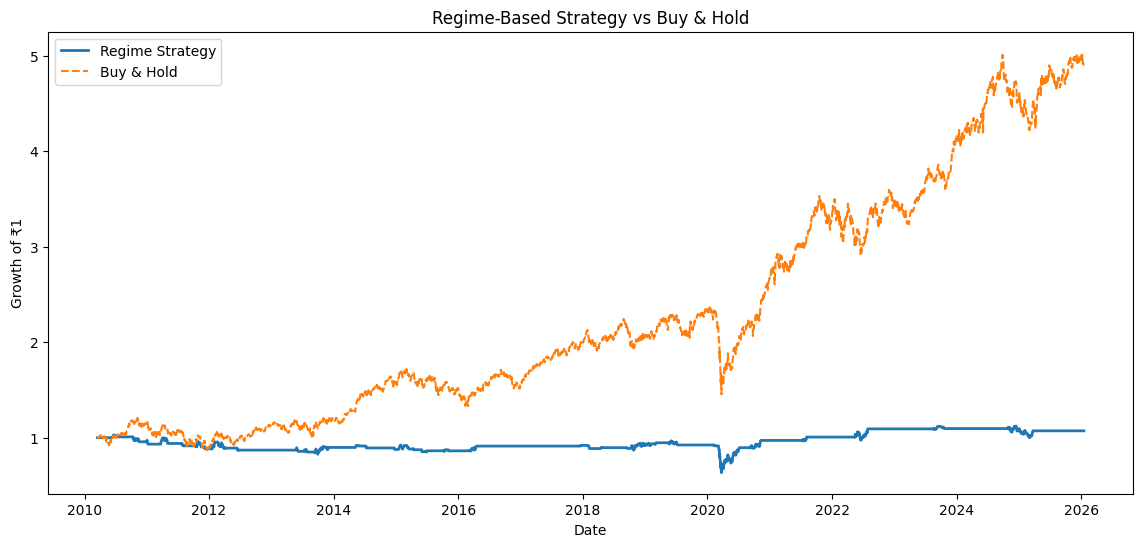

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(
    bt_df.index,
    bt_df["equity_curve"],
    label="Regime Strategy",
    linewidth=2
)

plt.plot(
    bt_df.index,
    (1 + bt_df["market_return"]).cumprod(),
    label="Buy & Hold",
    linestyle="--"
)

plt.title("Regime-Based Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.show()


In [35]:
bt_df = backtest_strategy(
    features_df,
    transaction_cost=0.001,
    slippage=0.0005
)


regime wise pNl breakdown

In [36]:
bt_df[["regime_name", "strategy_return"]].head()


Price,regime_name,strategy_return
Date,,
2010-03-18,Bear,0.0
2010-03-19,Bear,0.0
2010-03-22,Bear,-0.0
2010-03-23,Bear,0.0
2010-03-25,Bear,0.0


In [37]:
regime_annual_returns = (
    bt_df.groupby("regime_name")["strategy_return"]
    .mean() * 252
)

regime_annual_returns


regime_name
Bear        0.007367
Bull       -0.031055
Sideways    0.041375
Name: strategy_return, dtype: float64

In [38]:
regime_sharpe = bt_df.groupby("regime_name")["strategy_return"].apply(sharpe_ratio)

regime_sharpe


regime_name
Bear        0.520273
Bull       -0.327264
Sideways    0.313292
Name: strategy_return, dtype: float64

In [39]:
regime_drawdown = (
    bt_df.groupby("regime_name")["equity_curve"]
    .apply(max_drawdown)
)

regime_drawdown


regime_name
Bear       -0.145751
Bull       -0.197654
Sideways   -0.345845
Name: equity_curve, dtype: float64

In [40]:
regime_summary = pd.DataFrame({
    "Annual Return": regime_annual_returns,
    "Sharpe Ratio": regime_sharpe,
    "Max Drawdown": regime_drawdown
})

regime_summary


,Annual Return,Sharpe Ratio,Max Drawdown
regime_name,,,
Bear,0.007367,0.520273,-0.145751
Bull,-0.031055,-0.327264,-0.197654
Sideways,0.041375,0.313292,-0.345845
